# Classification of CIFAR-10 with Convolutional Neural Networks
### Author: Jack Burgemeister

## Abstract:
This project aims to demonstrate and analyse the performance of several state-of-the-art CNN architectures through the classification of the CIFAR-10 dataset. The CNNs tested within this project will include variants of both the VGG and ResNet architectures.

## Overview:

0. Dataset and Pre-Processing
1. Data Visualisation.
3. Training Methodology (Supporting Functions and Performance Metrics).
4. Baseline Model.
5. CNN Architecture.  
  5.1. VGG-16  
  5.2. VGG-19  
  5.3. ResNet-18  
  5.4. ResNet-34  
  5.5. ResNet-50  
6. Results Comparison

## Dataset:
As noted within the abstract summary, this project will make use of the CIFAR-10 dataset accessible via kaggle `https://www.kaggle.com/c/cifar-10/`. Given torchvision's built-in access to this data, the `torchvision.datasets` API will be used to access the dataset for this project.

In [1]:
# Libraries
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import vgg16, vgg19, resnet18, resnet34, resnet50
from torchsummary import summary
import time
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Seed Setting Function
def set_seed():
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

# Setting Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on ... {device}")

Running on ... cuda


# Section 0: Dataset and Pre-Processing
1. **Load Dataset via Torchvision.datasets API.**
2. **Apply Pre-Processing on Load Action.**  
  a. Resize Images to 224x224 (per requirements of torchvision.models `https://pytorch.org/vision/0.9/models.html#id2`).  
  b. Convert pixels to a range of [0,1].  
  c. Normalize per Torchvision Requirements
3. **Create DataLoader Objects.**  
  a. Training Set (70%).  
  b. Validation Set (15%).  
  c. Test Set (15%).

In [3]:
set_seed()
# Defining Transform per Torchvision Documentation
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                                ])

# Downloading Dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform = transform, download=True)
train_data, val_data = random_split(train_set,[40000,10000])
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform = transform, download=True)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Dataset Numbers
print(f"Training Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Testing Samples: {len(test_data)}")

Training Samples: 40000
Validation Samples: 10000
Testing Samples: 10000


In [5]:
set_seed()
# Creating DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True) #shuffling training set for added normalisation
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 32, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = 32, shuffle = False)

# Section 1: Data Visualisation  
1. **View Data Samples and Size for Each Class**.

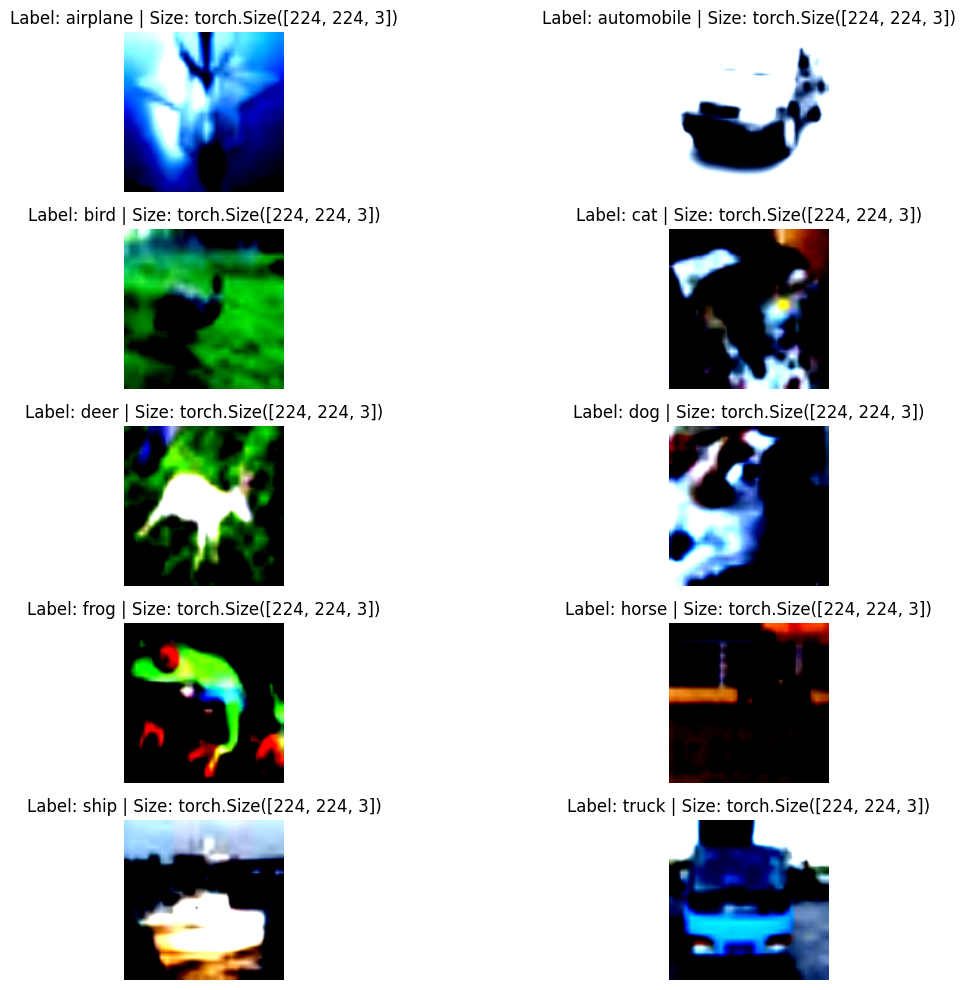

In [6]:
# Data Sampling
class_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

def get_image(desired_label,dataset):
  """
  Takes a desired label and a dataset and returns a random image with that label.
  """
  for image,label in train_data:
    if label == desired_label:
      return image

# Defining Subplot for 10 Classes
fig,ax = plt.subplots(figsize=(15,10),nrows=5,ncols=2)
axes = ax.ravel()

for i in range(10):
  im = get_image(i,train_data).permute(1,2,0)
  axes[i].imshow(im)
  axes[i].set_title(f"Label: {class_dict[i]} | Size: {im.size()}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

#Section 2: Training Methodology
The training methodology within this study will be functionised to enable consistency across models and minimise bias. The functions required and thus defined in this chapter include:

1. **Performance Metric Functions** - Top-1 Accuracy, Floating Point Operations (FLOPs).
3. **Visualisation** - Plot Loss Curves, Plot Confusion Matrix.
4. **Training Loops** - Training and Validation functions for 1 epoch of the respective datasets.
5. **Evaluation Function** - Evalute trained model on test set and return results.


### 2.1 Performance Metric Functions
* Accuracy
* FLOPs

In [7]:
# Accuracy Function
def accuracy_fn(y_pred, y_true):
  """
  Calculates and returns the decimal accuracy of the provided inputs
  """
  correct = torch.eq(y_pred,y_true).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [8]:
# Flops Calculation
def calculate_flops(model, input):
  """
  Calculate and return the FLOPs (Floating Point Operations) of a given model and input tensor.
  """
  list_conv = []

  def conv_hook(self, input, output):
      kernel_ops = (self.in_channels / self.groups) * 2 - 1  # add operations is one less to the mul operations
      for i in self.kernel_size:
          kernel_ops *= i
      bias_ops = 1 if self.bias is not None else 0

      params = kernel_ops + bias_ops
      flops = params * output[0].nelement()

      list_conv.append(flops)

  list_linear = []

  def linear_hook(self, input, output):
      weight_ops = (2 * self.in_features - 1) * output.nelement()
      bias_ops = self.bias.nelement()
      flops = weight_ops + bias_ops
      list_linear.append(flops)

  list_bn = []

  def bn_hook(self, input, output):
      # (x-x')/σ one sub op and one div op
      # and the shift γ and β
      list_bn.append(input[0].nelement() / input[0].size(0) * 4)

  list_relu = []

  def relu_hook(self, input, output):
      # every input's element need to cmp with 0
      list_relu.append(input[0].nelement() / input[0].size(0))

  list_pooling = []

  def max_pooling_hook(self, input, output):
      if isinstance(self.kernel_size, tuple):
          kernel_ops = torch.prod(torch.Tensor([self.kernel_size]))
      else:
          kernel_ops = self.kernel_size * self.kernel_size
          if len(output[0].size()) > 3:  # 3D max pooling
              kernel_ops *= self.kernel_size
      flops = kernel_ops * output[0].nelement()
      list_pooling.append(flops)

  def avg_pooling_hook(self, input, output):
      if isinstance(self.kernel_size, tuple):
          kernel_ops = torch.prod(torch.Tensor([self.kernel_size]))
      else:
          kernel_ops = self.kernel_size * self.kernel_size
          if len(output[0].size()) > 3:  # 3D  pooling
              kernel_ops *= self.kernel_size
      flops = (kernel_ops + 1) * output[0].nelement()
      list_pooling.append(flops)

  def adaavg_pooling_hook(self, input, output):
      kernel = torch.Tensor([*(input[0].shape[2:])]) // torch.Tensor(list((self.output_size,))).squeeze()
      kernel_ops = torch.prod(kernel)
      flops = (kernel_ops + 1) * output[0].nelement()
      list_pooling.append(flops)

  def adamax_pooling_hook(self, input, output):
      kernel = torch.Tensor([*(input[0].shape[2:])]) // torch.Tensor(list((self.output_size,))).squeeze()
      kernel_ops = torch.prod(kernel)
      flops = kernel_ops * output[0].nelement()
      list_pooling.append(flops)

  def foo(net):
      childrens = list(net.children())
      if not childrens:
          if isinstance(net, torch.nn.Conv2d) or isinstance(net, torch.nn.Conv3d):
              net.register_forward_hook(conv_hook)
          if isinstance(net, torch.nn.Linear):
              net.register_forward_hook(linear_hook)
          if isinstance(net, torch.nn.BatchNorm2d) or isinstance(net, torch.nn.BatchNorm3d):
              net.register_forward_hook(bn_hook)
          if isinstance(net, torch.nn.ReLU):
              net.register_forward_hook(relu_hook)
          if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.MaxPool3d):
              net.register_forward_hook(max_pooling_hook)
          if isinstance(net, torch.nn.AvgPool2d) or isinstance(net, torch.nn.AvgPool3d):
              net.register_forward_hook(avg_pooling_hook)
          if isinstance(net, torch.nn.AdaptiveAvgPool2d) or isinstance(net, torch.nn.AdaptiveAvgPool3d):
              net.register_forward_hook(adaavg_pooling_hook)
          if isinstance(net, torch.nn.AdaptiveMaxPool2d) or isinstance(net, torch.nn.AdaptiveMaxPool3d):
              net.register_forward_hook(adamax_pooling_hook)
          return
      for c in childrens:
          foo(c)

  foo(model)
  out = model(input)
  total_flops = sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling)

  if isinstance(total_flops, torch.Tensor):
      total_flops = total_flops.item()

  return (total_flops / 1e9)

### 2.2 Visualisation
* Plot Loss Curves
* Plot Confusion Matrix



In [9]:
# Plot Loss Curves
def plot_loss_curves(train_loss,
                     train_acc,
                     val_loss,
                     val_acc,
                     title):
  """
  Plots the loss/accuracy curves of a trained model
  """
  # Adjusting/Extracting Vectors
  num_epochs = len(train_loss)
  # train_loss, train_acc, val_loss, val_acc = train_loss.cpu(), train_acc.cpu(), val_loss.cpu(), val_acc.cpu()

  # Printing Figure
  plt.figure(figsize=(10,7))

  plt.subplot(121)
  plt.plot(range(num_epochs),train_loss,label="Training Loss")
  plt.plot(range(num_epochs),val_loss,label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"Loss Curve - {title}")

  plt.subplot(122)
  plt.plot(range(num_epochs),train_acc,label="Training Accuracy")
  plt.plot(range(num_epochs),val_acc,label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(f"Accuracy Curve - {title}")

  plt.tight_layout()
  plt.show()

In [10]:
# Plot Confusion Matrix
def plot_conf_matrix(y_pred,
                     y_true,
                     title
                     ):
  """
  Plots the confusion matrix of a trained model
  """
  # Moving Labels to Device
  y_pred = y_pred.cpu().numpy()
  y_true = y_true.cpu().numpy()

  # Making Confusion Matrix
  cm = confusion_matrix(y_true,y_pred)

  plt.figure(figsize=(20,12))
  plt.title(f"Confusion Matrix - {title}")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.values())
  disp.plot(ax=plt.gca(),cmap=plt.cm.Blues)
  plt.show()

### 2.3 Model Training Loops
* Train Loop
* Validation Loop

In [11]:
# Train Loop
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device
               ):
  """
  Evaluates the input model on 1 Epoch of Training Data
  """
  epoch_loss = 0.0
  epoch_acc = 0.0

  model.train()
  for x,y in dataloader:
    x,y = x.to(device),y.to(device)

    # 1. Forward Pass
    y_pred = model(x)

    # 2. Calculate Metrics
    loss = loss_fn(y_pred,y)
    epoch_acc += accuracy_fn(y_pred=torch.argmax(y_pred, dim=1),y_true=y)
    epoch_loss += loss.item()

    # 3. Zero Gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

  batch_loss = epoch_loss/len(dataloader)
  batch_acc = epoch_acc/len(dataloader)

  return batch_loss, batch_acc

In [12]:
# Validation Loop
def val_loop(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device
             ):
  """
  Evaluates the input model on 1 Epoch of Validation Data
  """
  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.inference_mode():
    for x,y in dataloader:
      x,y = x.to(device),y.to(device)

      #1. Forward Pass
      y_pred = model(x)

      #2. Calculate Metrics
      epoch_loss += loss_fn(y_pred,y).item()
      epoch_acc += accuracy_fn(y_pred=torch.argmax(y_pred, dim=1),y_true=y)

  batch_loss = epoch_loss/len(dataloader)
  batch_acc = epoch_acc/len(dataloader)

  return batch_loss, batch_acc

## 2.4 Evaluation Function
* Test/Evaluation Loop

In [13]:
# Evaluate Model
def test_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    """
    Evaluates the input model on 1 Epoch of Testing Data
    """
    epoch_loss = 0.0
    epoch_acc = 0.0
    y_predictions = list()
    y_labels = list()

    # Test Loop
    model.eval()
    with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            # 1. Forward Pass
            y_pred = model(x)

            # 2. Calculate Loss and Accuracy
            epoch_loss += loss_fn(y_pred, y).item()  # Use .item() to extract the scalar value
            epoch_acc += accuracy_fn(y_pred=torch.argmax(y_pred, dim=1), y_true=y)

            # Appending Labels + Predictions
            y_predictions.append(torch.argmax(y_pred, dim=1))
            y_labels.append(y)

        # Calculate the average loss and accuracy over all batches
        batch_loss = epoch_loss / len(dataloader)
        batch_acc = epoch_acc / len(dataloader)

        # Concatenating all Labels + Predictions
        y_predictions = torch.cat(y_predictions, dim=0)
        y_labels = torch.cat(y_labels, dim=0)

        # FLOPs calculation
        input_tensor = torch.randn(1, 3, 224,224).to(device)
        flops = calculate_flops(model, input_tensor)

        # Efficiency Calculation
        eff = batch_acc / flops

        results = {
            "Model Name": model.__class__.__name__,
            "Loss": np.round(batch_loss, 4),
            "Accuracy": np.round(batch_acc, 4),
            "FLOPs (G)": np.round(flops, 4),
            "Accuracy per FLOP": np.round(eff,4)
        }

    # Plotting Confusion Matrix (y_pred contains only the predictions from the last batch)
    plot_conf_matrix(y_pred=y_predictions, y_true=y_labels, title=model.__class__.__name__)

    return results

#Section 3: Baseline Model
Section 3 focusses on training and evaluating a simple CNN model to establish a performance baseline for the remainder of the study. The constant variables utilised within the baseline evaluation will remain throughout section 4.

**Contents**
1. Define Baseline Model Class.
2. Train and Evaluate Baseline Model.

In [14]:
class Baseline_CNN(nn.Module):
  def __init__(self,
               input_channels,
               hidden_units,
               output_channels):
    super().__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(input_channels,hidden_units,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(hidden_units * (224 // 2) * (224 // 2),output_channels),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    return self.cnn(x)

Epoch: 1 
--------
Training - Loss: 2.2680 | Accuracy: 19.3000 || Validation - Loss: 2.2428 | Accuracy: 21.8251
--------
Epoch: 2 
--------
Training - Loss: 2.3241 | Accuracy: 13.7025 || Validation - Loss: 2.2726 | Accuracy: 18.8498
--------
Epoch: 3 
--------
Training - Loss: 2.2817 | Accuracy: 17.9475 || Validation - Loss: 2.3387 | Accuracy: 12.2404
--------
Epoch: 4 
--------
Training - Loss: 2.2936 | Accuracy: 16.7500 || Validation - Loss: 2.3001 | Accuracy: 16.1042
--------
Epoch: 5 
--------
Training - Loss: 2.2822 | Accuracy: 17.8900 || Validation - Loss: 2.2360 | Accuracy: 22.5140
--------
Epoch: 6 
--------
Training - Loss: 2.2453 | Accuracy: 21.5725 || Validation - Loss: 2.2763 | Accuracy: 18.4904
--------
Epoch: 7 
--------
Training - Loss: 2.2807 | Accuracy: 18.0400 || Validation - Loss: 2.2477 | Accuracy: 21.3458
--------
Epoch: 8 
--------
Training - Loss: 2.2621 | Accuracy: 19.9025 || Validation - Loss: 2.2586 | Accuracy: 20.2576
--------
Epoch: 9 
--------
Training - Lo

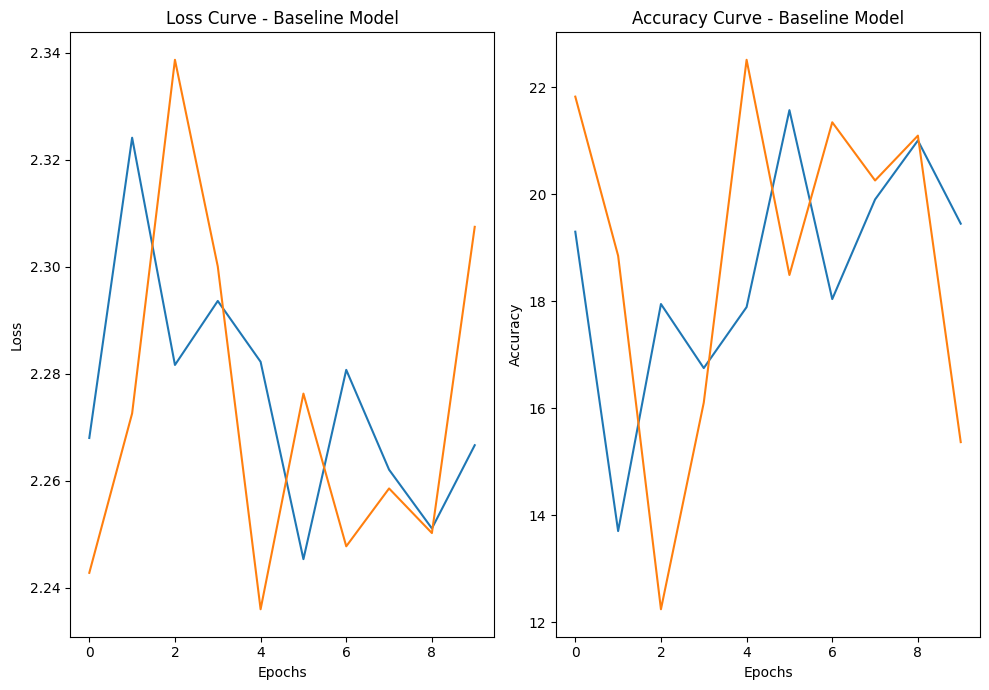

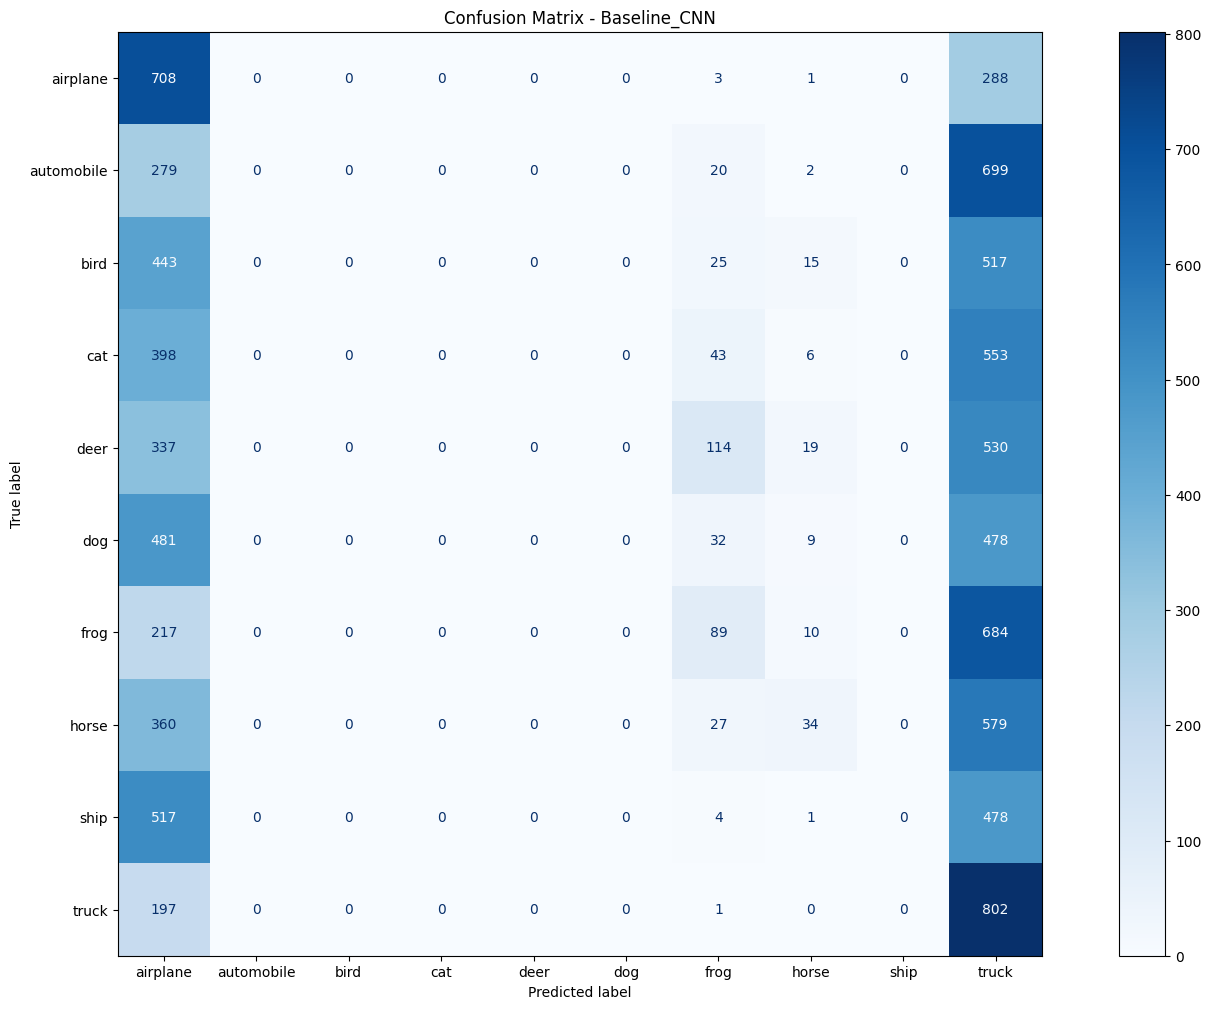

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,Baseline_CNN,2.298,16.3139,0.0425,383.4121,634.936


In [15]:
# Training/Evaluating Baseline Model
set_seed()

epochs = 10
base_model = Baseline_CNN(input_channels = 3,hidden_units = 16, output_channels = len(class_dict)).to(device)
optimizer = torch.optim.Adam(params=base_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=base_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=base_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="Baseline Model")

# Final Evaluation
baseline_results = test_loop(model=base_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
baseline_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(baseline_results,index=[0])
results_df

#Section 4: CNN Architecture
Section 4 focusses on assessing the ability of multiple VGG and ResNet architectures to classify the CIFAR-10 dataset.

**Model Architectures to be Tested**  
1. VGG-16.
2. VGG-19.
3. ResNet-18.
4. ResNet-34.
5. ResNet-50.

**Contents for Each Model Architecture**  
1. Load Pre-Trained model from `torchvision.models`.
2. Freeze Feature Extraction Layers.
3. Train Classifier Layers on CIFAR-10 dataset.
4. Evaluate Model on Test Set.

## 5.1. VGG-16

In [16]:
# Model Preparation
set_seed()

# Load Model from Torchvision
vgg16_model = vgg16(weights="IMAGENET1K_V1").to(device)

# Freezing Feature Extraction Layers
for param in vgg16_model.features.parameters():
  param.requires_grad = False

# Modifying Final Classifier to suit CIFAR-10
vgg16_model.classifier[-1] = nn.Linear(vgg16_model.classifier[-1].in_features, len(class_dict)).to(device)

# Print Model Summary
summary(vgg16_model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 190MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Epoch: 1 
--------
Training - Loss: 0.8990 | Accuracy: 74.1850 || Validation - Loss: 0.6138 | Accuracy: 79.3431
--------
Epoch: 2 
--------
Training - Loss: 0.6744 | Accuracy: 81.7725 || Validation - Loss: 0.4759 | Accuracy: 85.8626
--------
Epoch: 3 
--------
Training - Loss: 0.5727 | Accuracy: 84.9950 || Validation - Loss: 0.5136 | Accuracy: 85.3834
--------
Epoch: 4 
--------
Training - Loss: 0.5360 | Accuracy: 86.4475 || Validation - Loss: 0.4909 | Accuracy: 86.2720
--------
Epoch: 5 
--------
Training - Loss: 0.4703 | Accuracy: 88.3550 || Validation - Loss: 0.5564 | Accuracy: 84.6945
--------
Epoch: 6 
--------
Training - Loss: 0.4355 | Accuracy: 89.3400 || Validation - Loss: 0.5009 | Accuracy: 85.8427
--------
Epoch: 7 
--------
Training - Loss: 0.4002 | Accuracy: 90.3750 || Validation - Loss: 0.4931 | Accuracy: 86.8510
--------
Epoch: 8 
--------
Training - Loss: 0.3936 | Accuracy: 90.8150 || Validation - Loss: 0.5504 | Accuracy: 87.6498
--------
Epoch: 9 
--------
Training - Lo

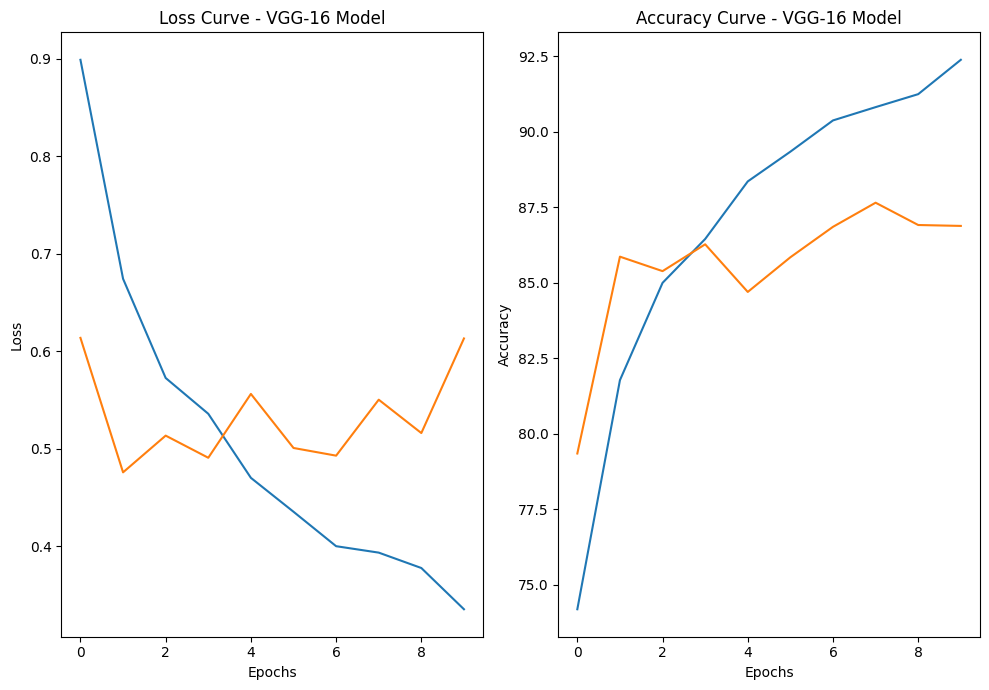

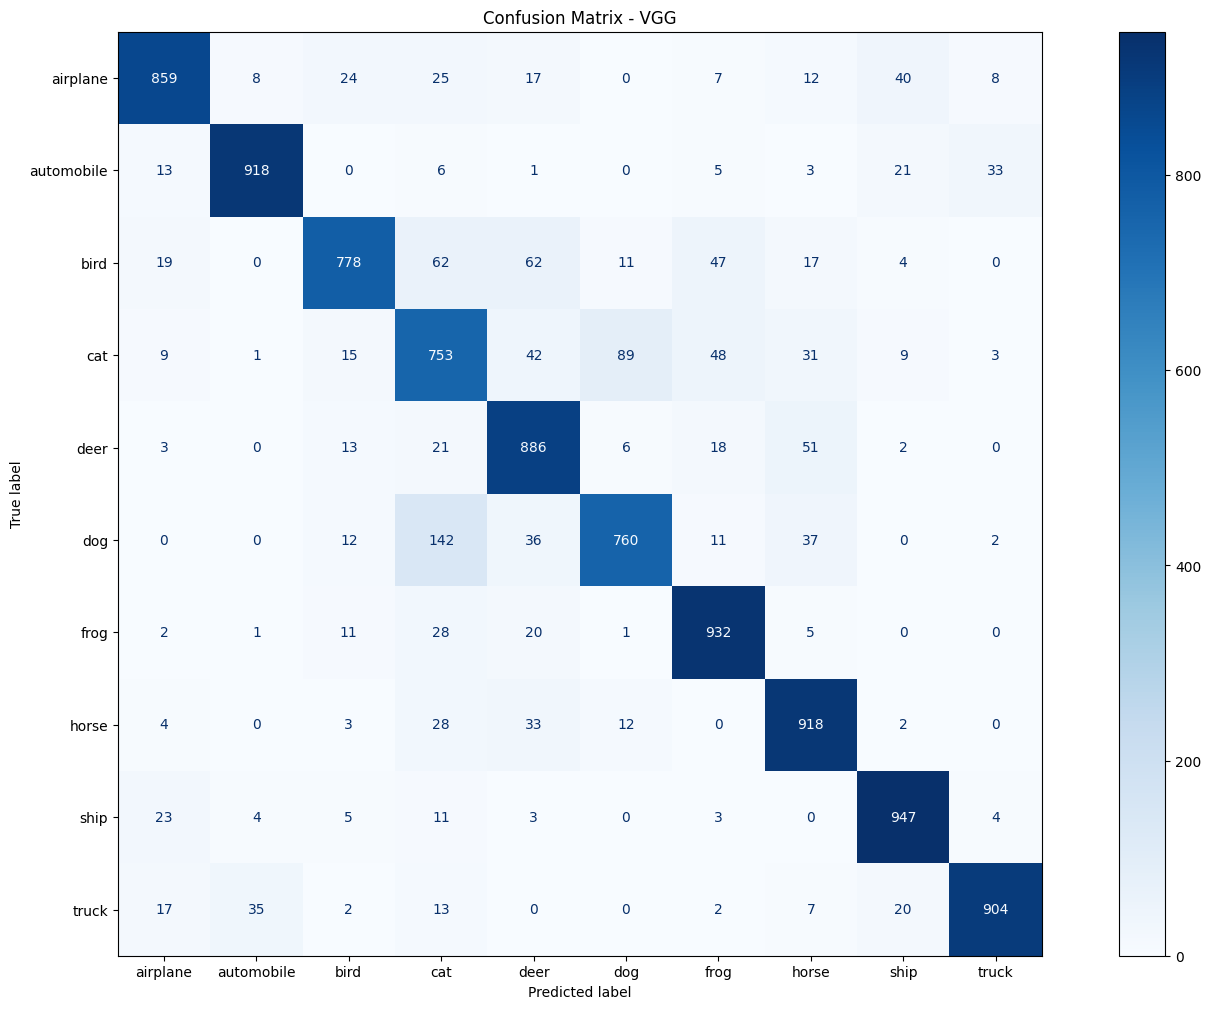

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,VGG,0.7105,86.5415,30.8438,2.8058,879.056


In [17]:
# Training/Evaluating VGG16
set_seed()

epochs = 10
optimizer = torch.optim.Adam(params=vgg16_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=vgg16_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=vgg16_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="VGG-16 Model")

# Final Evaluation
vgg16_results = test_loop(model=vgg16_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
vgg16_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(vgg16_results,index=[0])
results_df

##5.2. VGG-19

In [18]:
set_seed()
# Load Model from TorchVvision
vgg19_model = vgg19(weights="IMAGENET1K_V1").to(device)

# Freezing Feature Extraction Layers
for param in vgg19_model.features.parameters():
  param.requires_grad = False

# Modifying Final Classifier to suit CIFAR-10
vgg19_model.classifier[-1] = nn.Linear(vgg19_model.classifier[-1].in_features, len(class_dict)).to(device)

# Print Model Summary
summary(vgg19_model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 231MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Epoch: 1 
--------
Training - Loss: 0.9009 | Accuracy: 74.2475 || Validation - Loss: 0.6462 | Accuracy: 80.6410
--------
Epoch: 2 
--------
Training - Loss: 0.6953 | Accuracy: 81.1825 || Validation - Loss: 0.4784 | Accuracy: 85.3035
--------
Epoch: 3 
--------
Training - Loss: 0.5764 | Accuracy: 84.2275 || Validation - Loss: 0.5048 | Accuracy: 84.9740
--------
Epoch: 4 
--------
Training - Loss: 0.5332 | Accuracy: 86.1175 || Validation - Loss: 0.4616 | Accuracy: 86.9808
--------
Epoch: 5 
--------
Training - Loss: 0.4915 | Accuracy: 87.3875 || Validation - Loss: 0.4970 | Accuracy: 86.5915
--------
Epoch: 6 
--------
Training - Loss: 0.4634 | Accuracy: 88.2050 || Validation - Loss: 0.5113 | Accuracy: 86.2420
--------
Epoch: 7 
--------
Training - Loss: 0.4024 | Accuracy: 89.9375 || Validation - Loss: 0.5101 | Accuracy: 87.5399
--------
Epoch: 8 
--------
Training - Loss: 0.3847 | Accuracy: 90.7325 || Validation - Loss: 0.4959 | Accuracy: 86.5915
--------
Epoch: 9 
--------
Training - Lo

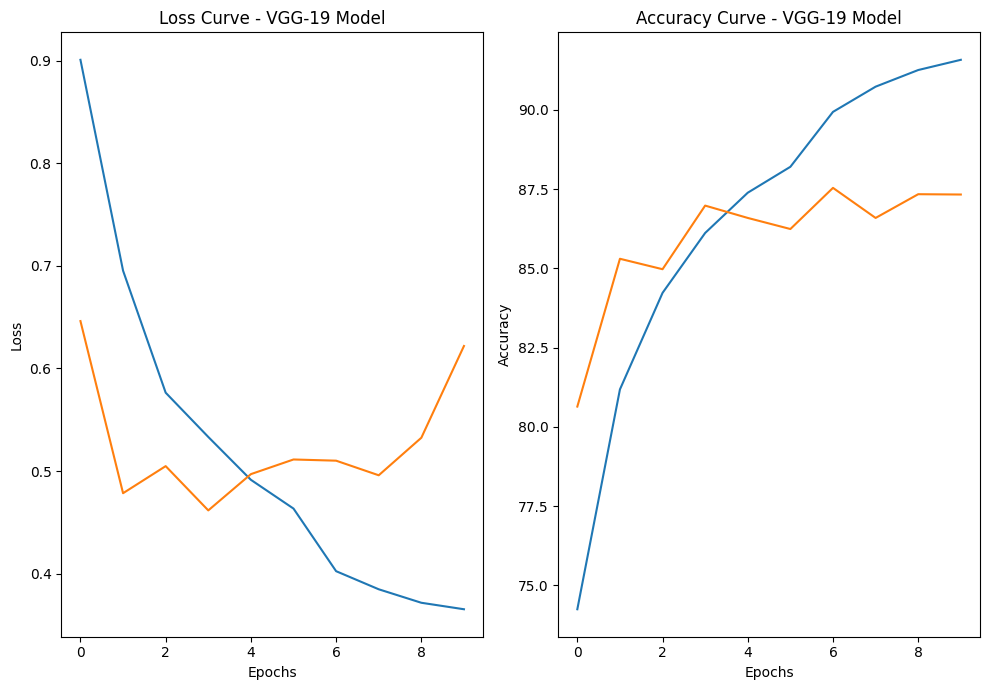

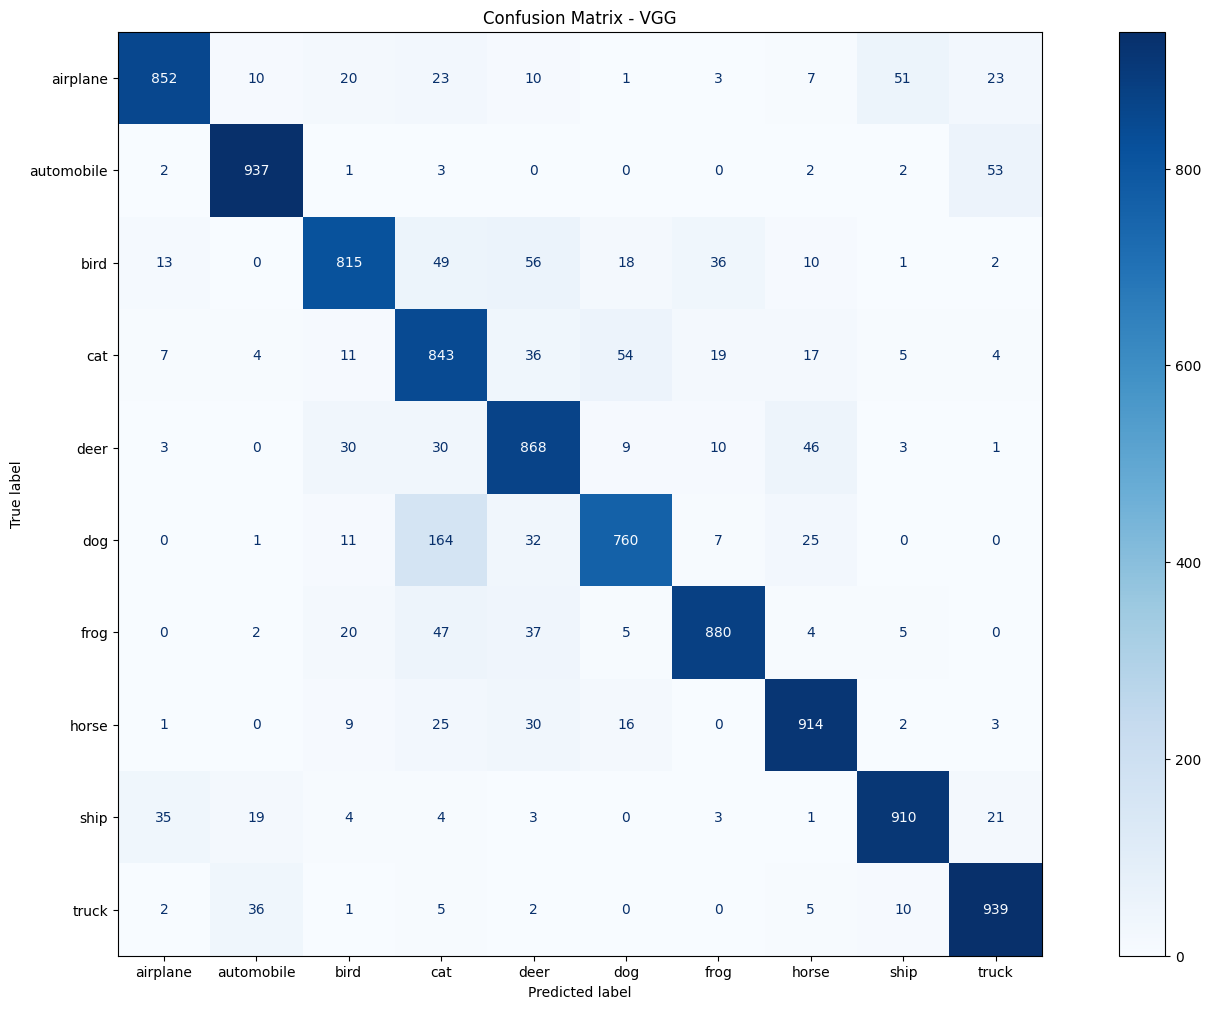

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,VGG,0.6275,87.1705,39.1582,2.2261,918.219


In [19]:
# Training/Evaluating VGG-19
set_seed()

epochs = 10
optimizer = torch.optim.Adam(params=vgg19_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=vgg19_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=vgg19_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="VGG-19 Model")

# Final Evaluation
vgg19_results = test_loop(model=vgg19_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
vgg19_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(vgg19_results,index=[0])
results_df

##5.3. ResNet-18

In [20]:
set_seed()
# Load Model from TorchVvision
resnet18_model = resnet18(weights="DEFAULT").to(device)

# Freezing Feature Extraction Layers
for param in resnet18_model.parameters():
  param.requires_grad = False

# Altering FC Layer to suit 10 Classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, len(class_dict)).to(device)

# Freezing Feature Extraction Layers
for param in resnet18_model.fc.parameters():
  param.requires_grad = True

# # Print Model Summary
summary(resnet18_model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch: 1 
--------
Training - Loss: 0.8344 | Accuracy: 72.3400 || Validation - Loss: 0.6223 | Accuracy: 78.7141
--------
Epoch: 2 
--------
Training - Loss: 0.6505 | Accuracy: 77.5825 || Validation - Loss: 0.5708 | Accuracy: 80.0619
--------
Epoch: 3 
--------
Training - Loss: 0.6264 | Accuracy: 78.3950 || Validation - Loss: 0.5650 | Accuracy: 80.4413
--------
Epoch: 4 
--------
Training - Loss: 0.6165 | Accuracy: 78.7425 || Validation - Loss: 0.5892 | Accuracy: 79.6026
--------
Epoch: 5 
--------
Training - Loss: 0.6078 | Accuracy: 78.8900 || Validation - Loss: 0.5577 | Accuracy: 80.5112
--------
Epoch: 6 
--------
Training - Loss: 0.6014 | Accuracy: 79.3075 || Validation - Loss: 0.5502 | Accuracy: 80.8007
--------
Epoch: 7 
--------
Training - Loss: 0.5932 | Accuracy: 79.4175 || Validation - Loss: 0.5408 | Accuracy: 81.3498
--------
Epoch: 8 
--------
Training - Loss: 0.5894 | Accuracy: 79.5225 || Validation - Loss: 0.5620 | Accuracy: 80.6310
--------
Epoch: 9 
--------
Training - Lo

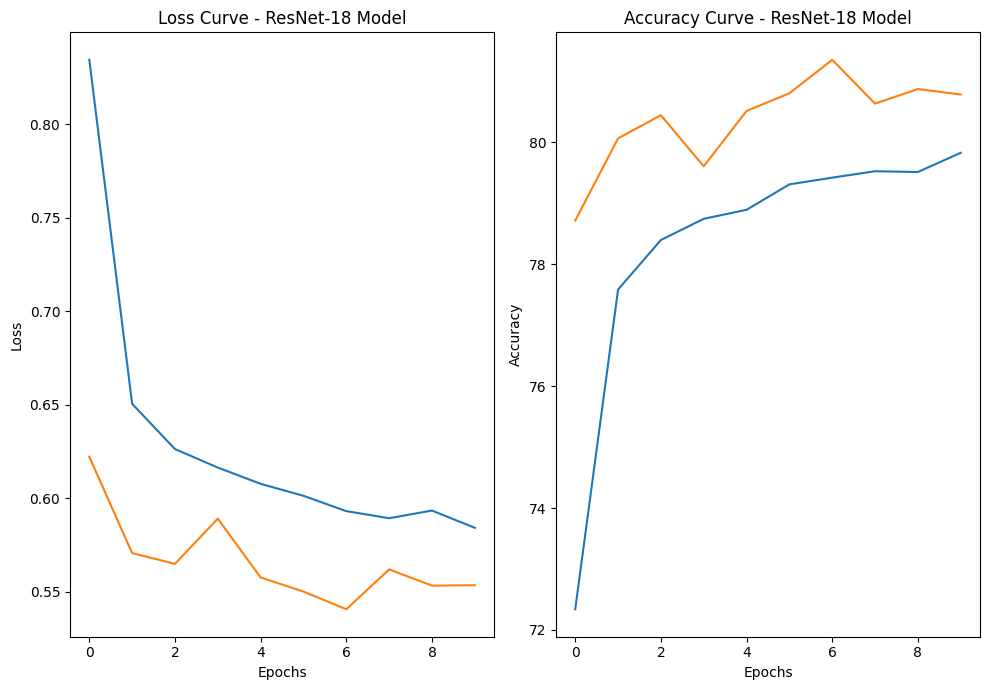

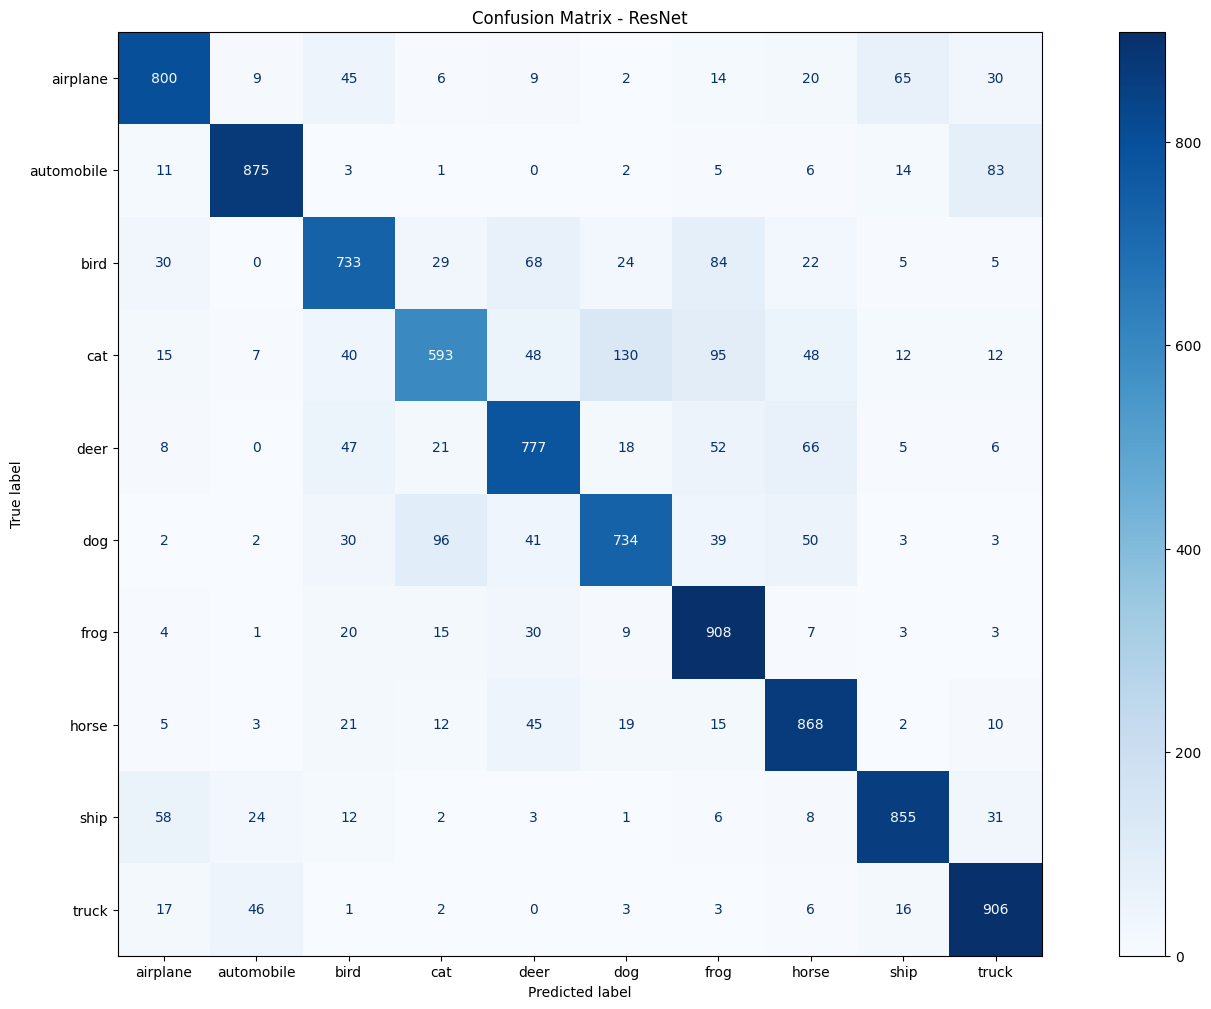

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,ResNet,0.5776,80.4912,3.5881,22.4325,673.364


In [21]:
# Training/Evaluating ResNet-18
set_seed()

epochs = 10
optimizer = torch.optim.Adam(params=resnet18_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=resnet18_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=resnet18_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="ResNet-18 Model")

# Final Evaluation
resnet18_results = test_loop(model=resnet18_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
resnet18_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(resnet18_results,index=[0])
results_df

## 5.4. ResNet-34

In [22]:
set_seed()
# Load Model from TorchVvision
resnet34_model = resnet34(weights="DEFAULT").to(device)

# Freezing Feature Extraction Layers
for param in resnet34_model.parameters():
  param.requires_grad = False

# Altering FC Layer to suit 10 Classes
resnet34_model.fc = nn.Linear(resnet34_model.fc.in_features, len(class_dict)).to(device)

# Freezing Feature Extraction Layers
for param in resnet34_model.fc.parameters():
  param.requires_grad = True

# # Print Model Summary
summary(resnet34_model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch: 1 
--------
Training - Loss: 0.8015 | Accuracy: 73.7025 || Validation - Loss: 0.5780 | Accuracy: 79.9521
--------
Epoch: 2 
--------
Training - Loss: 0.6179 | Accuracy: 78.8700 || Validation - Loss: 0.5356 | Accuracy: 81.4497
--------
Epoch: 3 
--------
Training - Loss: 0.5945 | Accuracy: 79.6100 || Validation - Loss: 0.5342 | Accuracy: 81.3798
--------
Epoch: 4 
--------
Training - Loss: 0.5883 | Accuracy: 79.6000 || Validation - Loss: 0.5520 | Accuracy: 81.1102
--------
Epoch: 5 
--------
Training - Loss: 0.5773 | Accuracy: 80.2750 || Validation - Loss: 0.5234 | Accuracy: 81.4996
--------
Epoch: 6 
--------
Training - Loss: 0.5643 | Accuracy: 80.4600 || Validation - Loss: 0.5313 | Accuracy: 81.2999
--------
Epoch: 7 
--------
Training - Loss: 0.5664 | Accuracy: 80.3975 || Validation - Loss: 0.5233 | Accuracy: 81.6693
--------
Epoch: 8 
--------
Training - Loss: 0.5573 | Accuracy: 80.9225 || Validation - Loss: 0.5151 | Accuracy: 81.7392
--------
Epoch: 9 
--------
Training - Lo

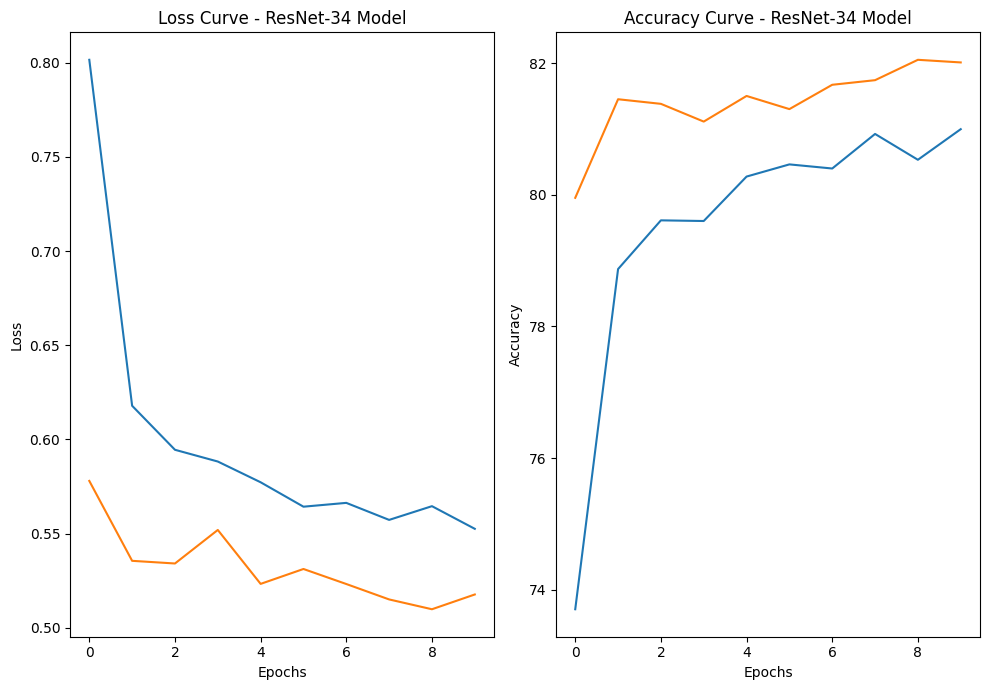

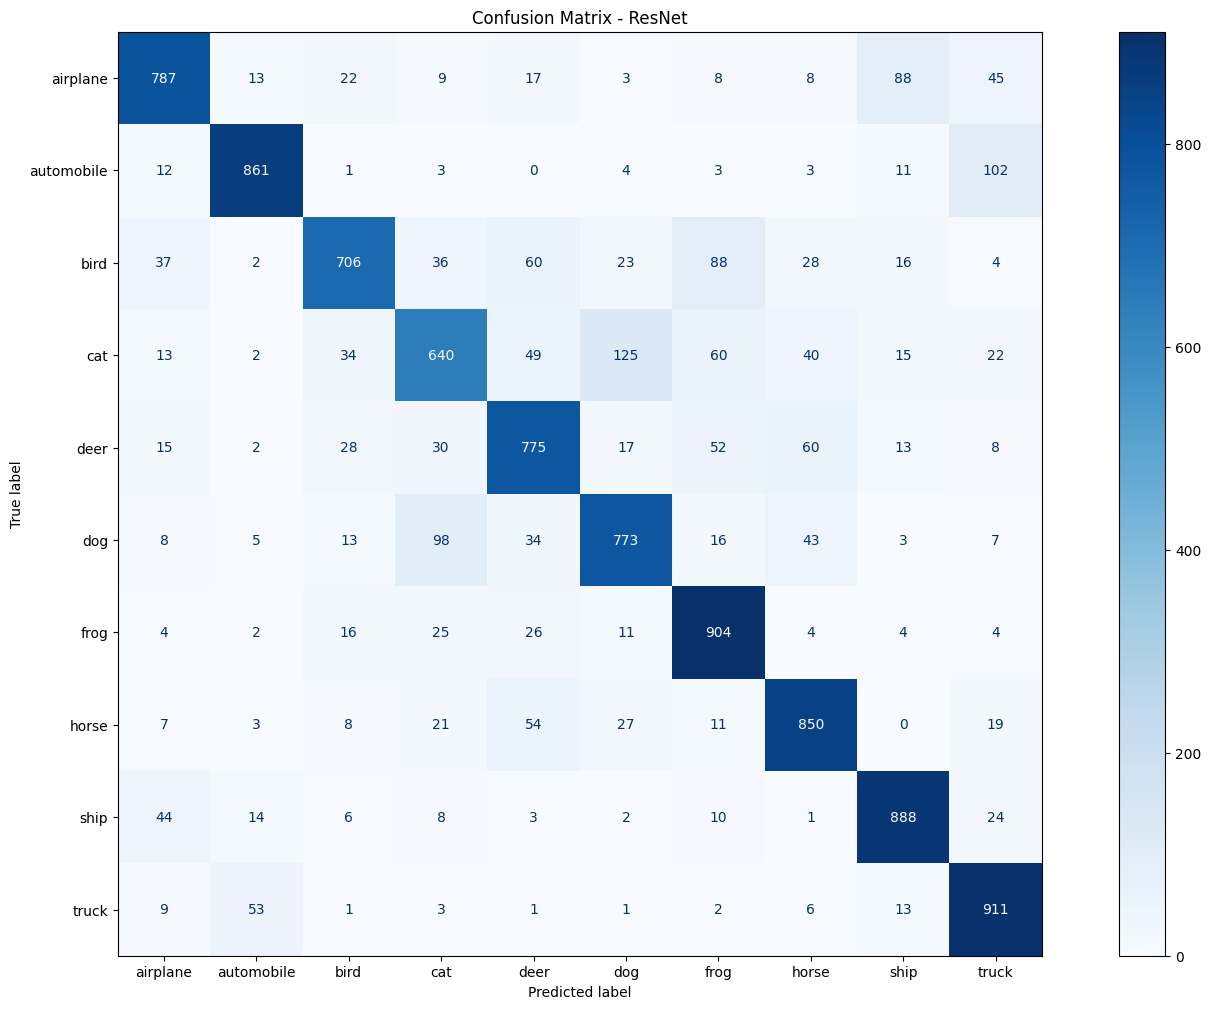

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,ResNet,0.5456,80.9505,7.2825,11.1157,720.981


In [23]:
# Training/Evaluating ResNet-34
set_seed()

epochs = 10
optimizer = torch.optim.Adam(params=resnet34_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=resnet34_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=resnet34_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="ResNet-34 Model")

# Final Evaluation
resnet34_results = test_loop(model=resnet34_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
resnet34_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(resnet34_results,index=[0])
results_df

##5.5. ResNet-50

In [24]:
set_seed()
# Load Model from TorchVvision
resnet50_model = resnet50(weights="DEFAULT").to(device)

# Freezing Feature Extraction Layers
for param in resnet50_model.parameters():
  param.requires_grad = False

# Altering FC Layer to suit 10 Classes
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, len(class_dict)).to(device)

# Freezing Feature Extraction Layers
for param in resnet50_model.fc.parameters():
  param.requires_grad = True

# # Print Model Summary
summary(resnet50_model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch: 1 
--------
Training - Loss: 0.8336 | Accuracy: 73.5850 || Validation - Loss: 0.6191 | Accuracy: 78.9637
--------
Epoch: 2 
--------
Training - Loss: 0.6102 | Accuracy: 79.6250 || Validation - Loss: 0.5673 | Accuracy: 80.7708
--------
Epoch: 3 
--------
Training - Loss: 0.5595 | Accuracy: 81.1475 || Validation - Loss: 0.5495 | Accuracy: 81.3798
--------
Epoch: 4 
--------
Training - Loss: 0.5272 | Accuracy: 82.1275 || Validation - Loss: 0.5370 | Accuracy: 81.5994
--------
Epoch: 5 
--------
Training - Loss: 0.5057 | Accuracy: 82.6750 || Validation - Loss: 0.5196 | Accuracy: 82.3283
--------
Epoch: 6 
--------
Training - Loss: 0.4938 | Accuracy: 83.0625 || Validation - Loss: 0.5233 | Accuracy: 82.3083
--------
Epoch: 7 
--------
Training - Loss: 0.4818 | Accuracy: 83.6400 || Validation - Loss: 0.5204 | Accuracy: 82.3682
--------
Epoch: 8 
--------
Training - Loss: 0.4733 | Accuracy: 83.8575 || Validation - Loss: 0.5316 | Accuracy: 81.9089
--------
Epoch: 9 
--------
Training - Lo

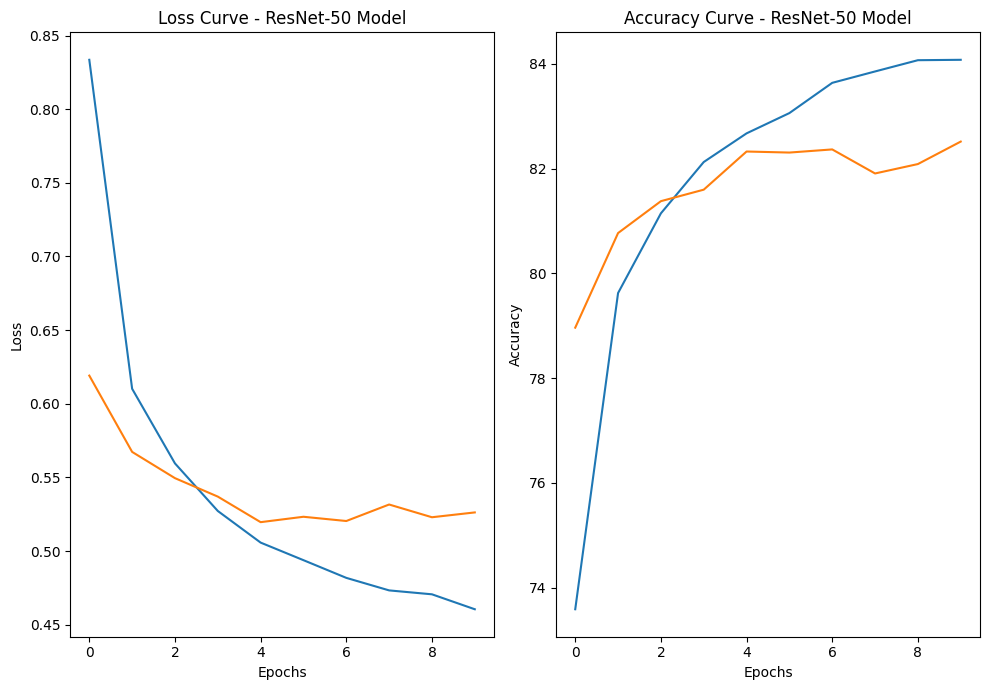

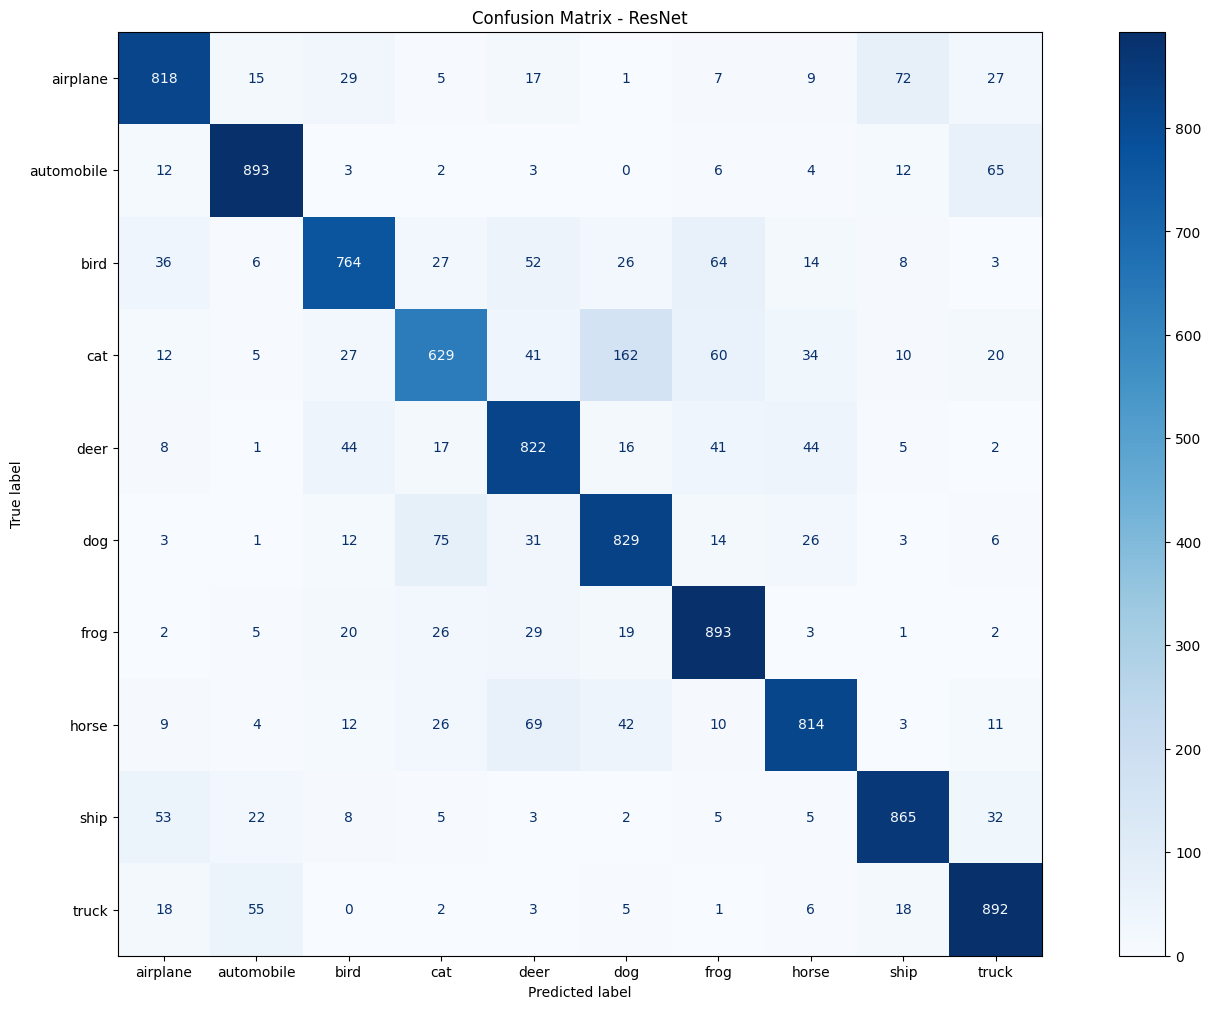

,Model Name,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
0,ResNet,0.5271,82.1785,8.1696,10.0591,828.545


In [25]:
# Training/Evaluating ResNet-50
set_seed()

epochs = 10
optimizer = torch.optim.Adam(params=resnet50_model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Start Training Timer
start_time = time.time()

for epoch in range(epochs):
  print(f"Epoch: {epoch+1} \n--------")
  tra_loss, tra_acc = train_loop(model=resnet50_model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device)

  va_loss, va_acc = val_loop(model=resnet50_model,
                               dataloader=val_loader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
  # Appending Data
  train_loss.append(tra_loss)
  train_acc.append(tra_acc)
  val_loss.append(va_loss)
  val_acc.append(va_acc)

  # Printing Losses
  print(f"Training - Loss: {tra_loss:.4f} | Accuracy: {tra_acc:.4f} || Validation - Loss: {va_loss:.4f} | Accuracy: {va_acc:.4f}")
  print("--------")

# Calculate Training Time
end_time = time.time()
elapsed_time = np.round(end_time - start_time,3)

# Printing Loss Curves
plot_loss_curves(train_loss=train_loss,
                 train_acc=train_acc,
                 val_loss=val_loss,
                 val_acc=val_acc,
                 title="ResNet-50 Model")

# Final Evaluation
resnet50_results = test_loop(model=resnet50_model,
                         dataloader=test_loader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         device=device)

# Printing Results Table
resnet50_results["Training Time (s)"] = elapsed_time
results_df = pd.DataFrame(resnet50_results,index=[0])
results_df

# Section 6: Results Comparison
Section 6 focusses on a comparative analysis of results uncovered within Section's 3 & 4.

In [26]:
# Results Collaboration and Visualisation
results_set = pd.DataFrame([vgg16_results,vgg19_results,resnet18_results,resnet34_results,resnet50_results])
results_set.index = ["VGG-16","VGG-19","ResNet-18","ResNet-34","ResNet-50"]
results_set = results_set.drop(columns=["Model Name"])
results_set

,Loss,Accuracy,FLOPs (G),Accuracy per FLOP,Training Time (s)
VGG-16,0.7105,86.5415,30.8438,2.8058,879.056
VGG-19,0.6275,87.1705,39.1582,2.2261,918.219
ResNet-18,0.5776,80.4912,3.5881,22.4325,673.364
ResNet-34,0.5456,80.9505,7.2825,11.1157,720.981
ResNet-50,0.5271,82.1785,8.1696,10.0591,828.545


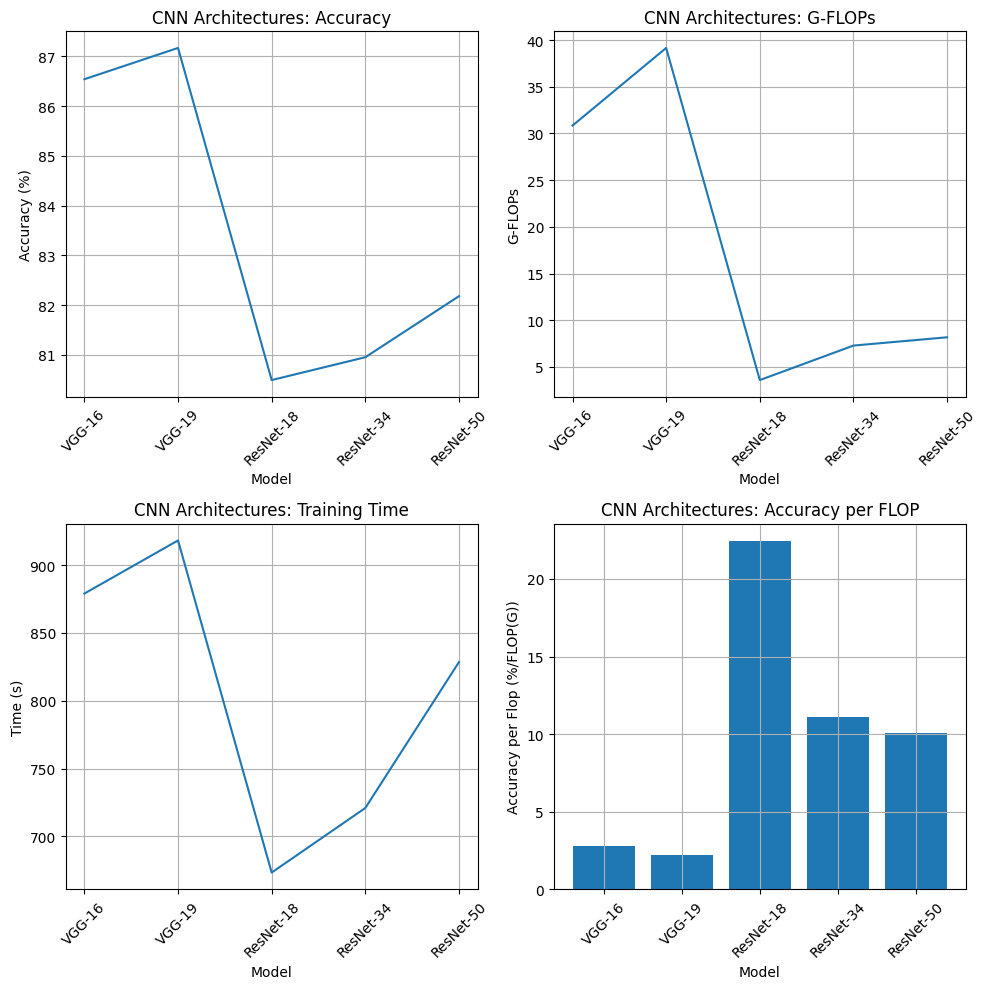

In [27]:
# Results Charts
plt.figure(figsize=(10,10))

# Accuracy
plt.subplot(2,2,1)
plt.plot(results_set.index,results_set["Accuracy"],label="Accuracy")
plt.title("CNN Architectures: Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.grid()

# FLOPs
plt.subplot(2,2,2)
plt.plot(results_set.index,results_set["FLOPs (G)"])
plt.title("CNN Architectures: G-FLOPs")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylabel("G-FLOPs")
plt.grid()

# Training Time
plt.subplot(2,2,3)
plt.plot(results_set.index,results_set["Training Time (s)"])
plt.title("CNN Architectures: Training Time")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylabel("Time (s)")
plt.grid()

# Accuracy per FLOP Chart
plt.subplot(2,2,4)
plt.bar(x=results_set.index,height=results_set["Accuracy per FLOP"])
plt.title("CNN Architectures: Accuracy per FLOP")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylabel("Accuracy per Flop (%/FLOP(G))")
plt.grid()

plt.tight_layout()
plt.show()